## Heart Attack Analysis & Classification using Principal Component Analysis

Installing Pycaret

In [3]:
!pip install pycaret


!pip install shap

!pip install pycaret[analysis]

Import Libraries

In [4]:
!pip install shap

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import *
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
import shap
plt.rcParams['figure.figsize'] = (7,5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
print("Pandas version: ", pd.__version__)
print("Seaborn version: ", sns.__version__)

Pandas version:  2.0.3
Seaborn version:  0.12.2


# Dataset:
**Age**: Age of the patient

**Sex**: Sex of the patient

**exang**: exercise induced angina (1 = yes; 0 = no)

**ca**: number of major vessels (0-3)

**cp** : Chest Pain type chest pain type

1.   *Value 1* : typical angina
2.   *Value 2* : atypical angina
3.   *Value 3* : non-anginal pain
4.   *Value 4* : asymptomatic


**trtbps** : resting blood pressure (in mm Hg)

**chol** : cholestoral in mg/dl fetched via BMI sensor

**fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

**rest_ecg** : resting electrocardiographic results

1.    *Value 0* : normal
2.    *Value 1* : having ST-T wave abnormality (T wave inversions and/or ST
      elevation or depression of > 0.05 mV)
3.    *Value 2* : showing probable or definite left ventricular hypertrophy by
      Estes' criteria

**thalach** : maximum heart rate achieved

**target** :
1. 0= less chance of heart attack
2. 1= more chance of heart attack


In [7]:
# Load data from drive
df = pd.read_csv('/content/sample_data/heart.csv')

df.head(100)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,53,1,0,142,226,0,0,111,1,0.0,2,0,3,1
96,62,0,0,140,394,0,0,157,0,1.2,1,0,2,1
97,52,1,0,108,233,1,1,147,0,0.1,2,3,3,1
98,43,1,2,130,315,0,1,162,0,1.9,2,1,2,1


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Dataset Cleanup

In [10]:
columns_to_drop = ['oldpeak', 'slp', 'thall', 'fbs', 'thalachh','exng', 'caa']

df = df.drop(columns=columns_to_drop)

In [11]:
df = df.drop_duplicates()

print("Number of duplicated rows is: ", df.duplicated().sum())

Number of duplicated rows is:  0


In [12]:
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

Number of rows with NaNs is:  0


Exploratory Data Analysis

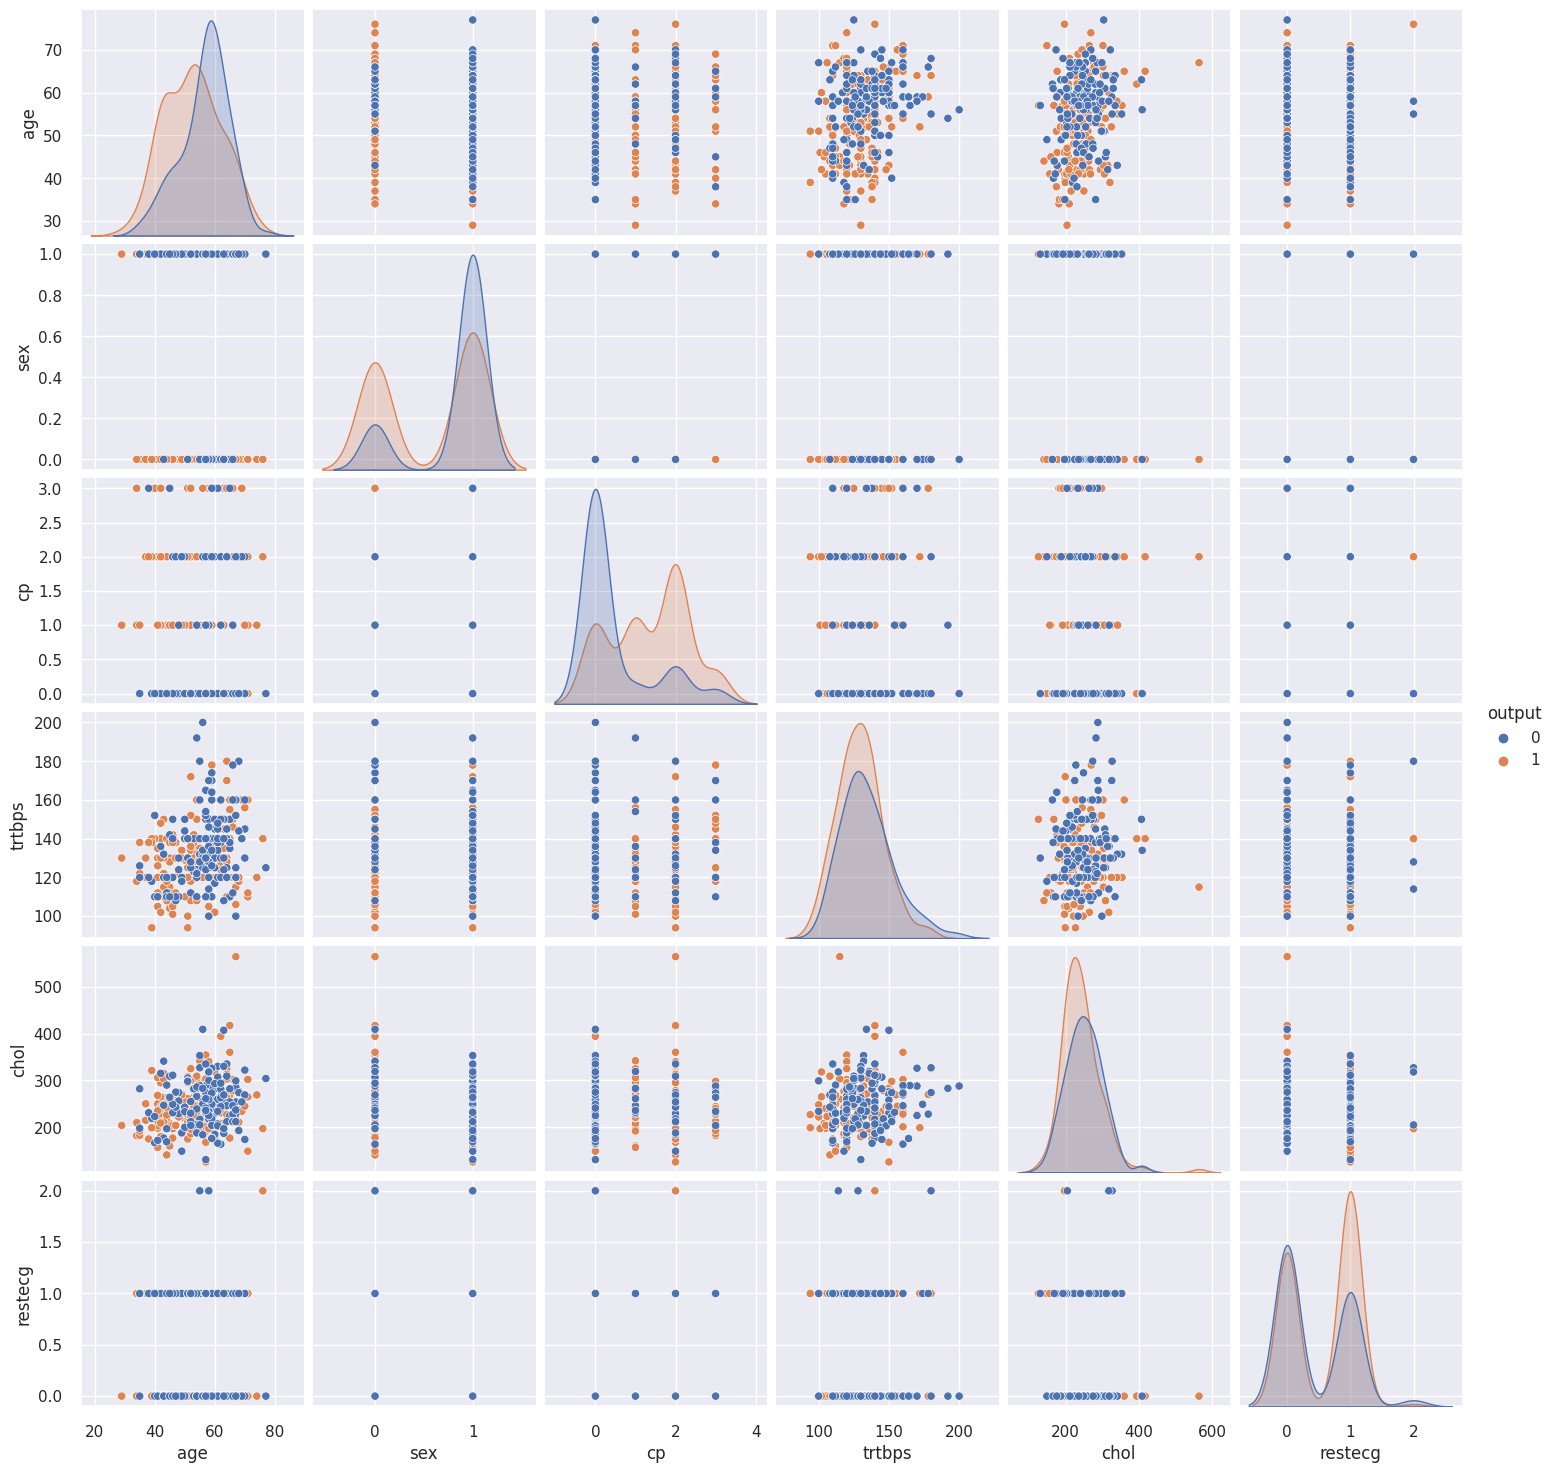

In [13]:
sns.pairplot(df, hue='output')
plt.show()

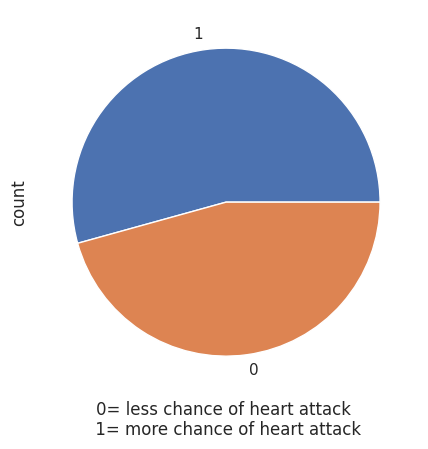

In [14]:
y =df['output']
y.value_counts().plot(kind='pie')
plt.xlabel('0= less chance of heart attack \n 1= more chance of heart attack')
plt.show()

Data Matrix

In [15]:
X = df.drop(columns=['output'])
X.head(100)

,age,sex,cp,trtbps,chol,restecg
0,63,1,3,145,233,0
1,37,1,2,130,250,1
2,41,0,1,130,204,0
3,56,1,1,120,236,1
4,57,0,0,120,354,1
...,...,...,...,...,...,...
95,53,1,0,142,226,0
96,62,0,0,140,394,0
97,52,1,0,108,233,1
98,43,1,2,130,315,1


Standardize the Data

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.0,55.5,61.00,77.0
sex,302.0,0.682119,0.466426,0.0,0.0,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.0,1.0,2.00,3.0
trtbps,302.0,131.602649,17.563394,94.0,120.0,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.0,240.5,274.75,564.0
restecg,302.0,0.526490,0.526027,0.0,0.0,1.0,1.00,2.0
output,302.0,0.543046,0.498970,0.0,0.0,1.0,1.00,1.0


In [17]:
Xs = StandardScaler().fit_transform(X)
Xcols = X.columns
X = pd.DataFrame(Xs)
X.columns = Xcols
X.head(100)

,age,sex,cp,trtbps,chol,restecg
0,0.949794,0.682656,1.976470,0.764066,-0.261285,-1.002541
1,-1.928548,0.682656,1.005911,-0.091401,0.067741,0.901657
2,-1.485726,-1.464866,0.035352,-0.091401,-0.822564,-1.002541
3,0.174856,0.682656,0.035352,-0.661712,-0.203222,0.901657
4,0.285561,-1.464866,-0.935208,-0.661712,2.080602,0.901657
...,...,...,...,...,...,...
95,-0.157260,0.682656,-0.935208,0.592972,-0.396766,-1.002541
96,0.839089,-1.464866,-0.935208,0.478910,2.854780,-1.002541
97,-0.267966,0.682656,-0.935208,-1.346085,-0.261285,0.901657
98,-1.264315,0.682656,1.005911,-0.091401,1.325779,0.901657


In [18]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,302.0,-2.588070e-16,1.00166,-2.814192,-0.710788,0.119503,0.728383,2.499671
sex,302.0,-1.176395e-16,1.00166,-1.464866,-1.464866,0.682656,0.682656,0.682656
cp,302.0,-1.411674e-16,1.00166,-0.935208,-0.935208,0.035352,1.005911,1.976470
trtbps,302.0,-7.058372e-16,1.00166,-2.144521,-0.661712,-0.091401,0.478910,3.900776
chol,302.0,8.822964e-18,1.00166,-2.332210,-0.687083,-0.116127,0.546763,6.145034
restecg,302.0,-2.352791e-17,1.00166,-1.002541,-1.002541,0.901657,0.901657,2.805854


Observations and Variables

In [19]:
observations = list(df.index)
variables = list(df.columns)

Box and Whisker Plots

[Text(0, 0, 'age'),
 Text(1, 0, 'sex'),
 Text(2, 0, 'cp'),
 Text(3, 0, 'trtbps'),
 Text(4, 0, 'chol'),
 Text(5, 0, 'restecg')]

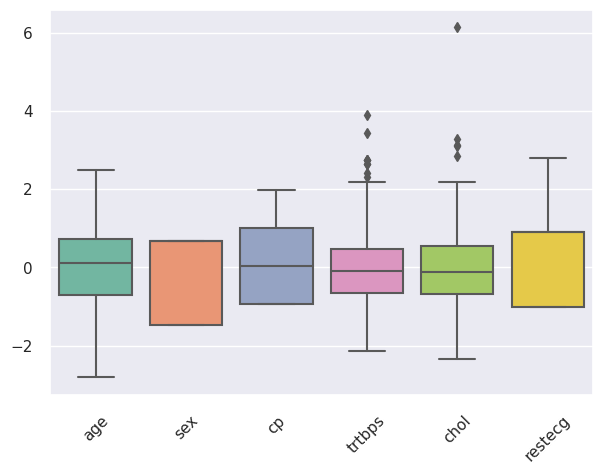

In [20]:
ax = plt.figure()
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

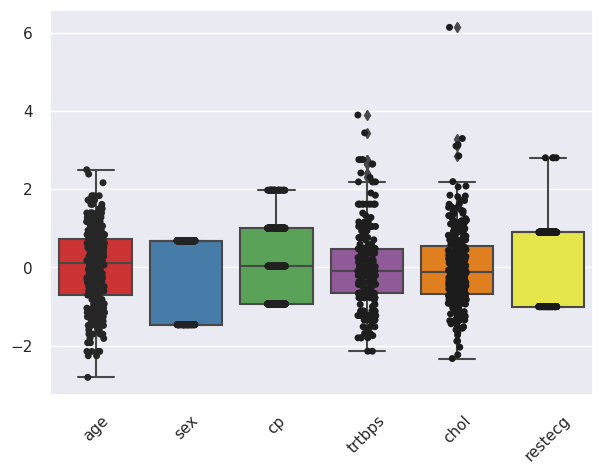

In [21]:
# Using swarmplot() or stripplot to show the datapoints on top of the boxes:
#plt. figure()
ax = plt.figure()
ax = sns.boxplot(data=X, orient="v", palette="Set1")
ax = sns.stripplot(data=X, color=".1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

Correlation Matrix

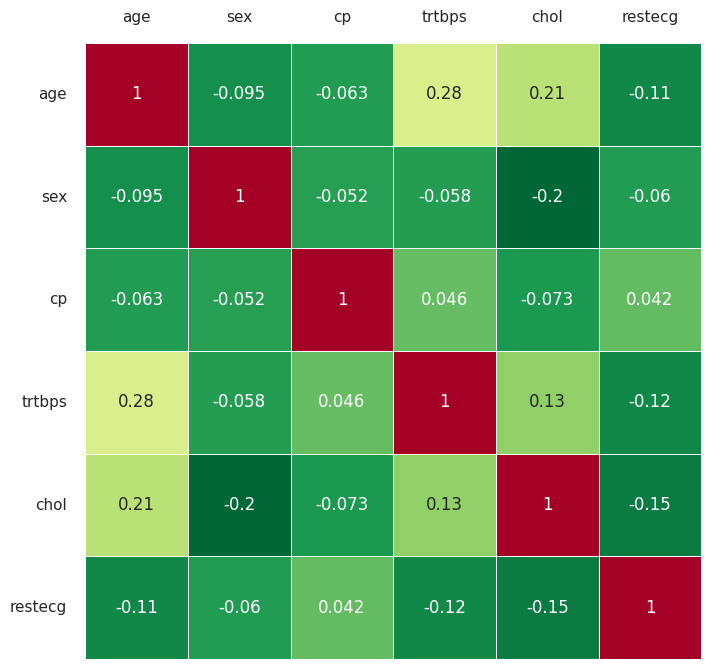

In [22]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(X.corr(), cmap='RdYlGn_r', linewidths=0.5, annot=True, cbar=False, square=True)
plt.yticks(rotation=0)
ax.tick_params(labelbottom=False,labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0);

#X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)
#sns.clustermap(X.corr(), annot=True, fmt='.2f')

## Principal Component Analysis

Using PCA Library

In [23]:
!pip install pca

In [24]:
from pca import pca
# Initialize and keep all PCs
model = pca()
# Fit transform
out = model.fit_transform(X)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


Principal Components

In [25]:
out['PC']

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.727753,-0.039493,2.318931,0.617295,0.429131,-0.676673
1,-1.657031,0.619390,0.509337,0.535358,0.662932,1.381375
2,-0.561626,0.494820,-0.201403,1.234579,-1.952941,0.324842
3,-0.814138,-0.010144,-0.117741,-0.592652,0.802751,-0.342866
4,1.103186,1.154743,-2.354612,0.038725,0.726336,0.240903
...,...,...,...,...,...,...
297,0.539606,0.960312,-0.984069,-1.076425,-0.886690,0.170260
298,-1.663133,1.090513,0.611511,1.032846,1.583439,0.049636
299,0.251737,-0.643286,0.327963,-2.248766,-0.055439,-0.583870
300,-1.429398,-0.694633,0.262087,-1.888759,-0.827202,-0.628204


Scatter Plot

[scatterd] >INFO> Create scatterplot


[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '6 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.9% expl.var)', ylabel='PC2 (18.4% expl.var)'>)

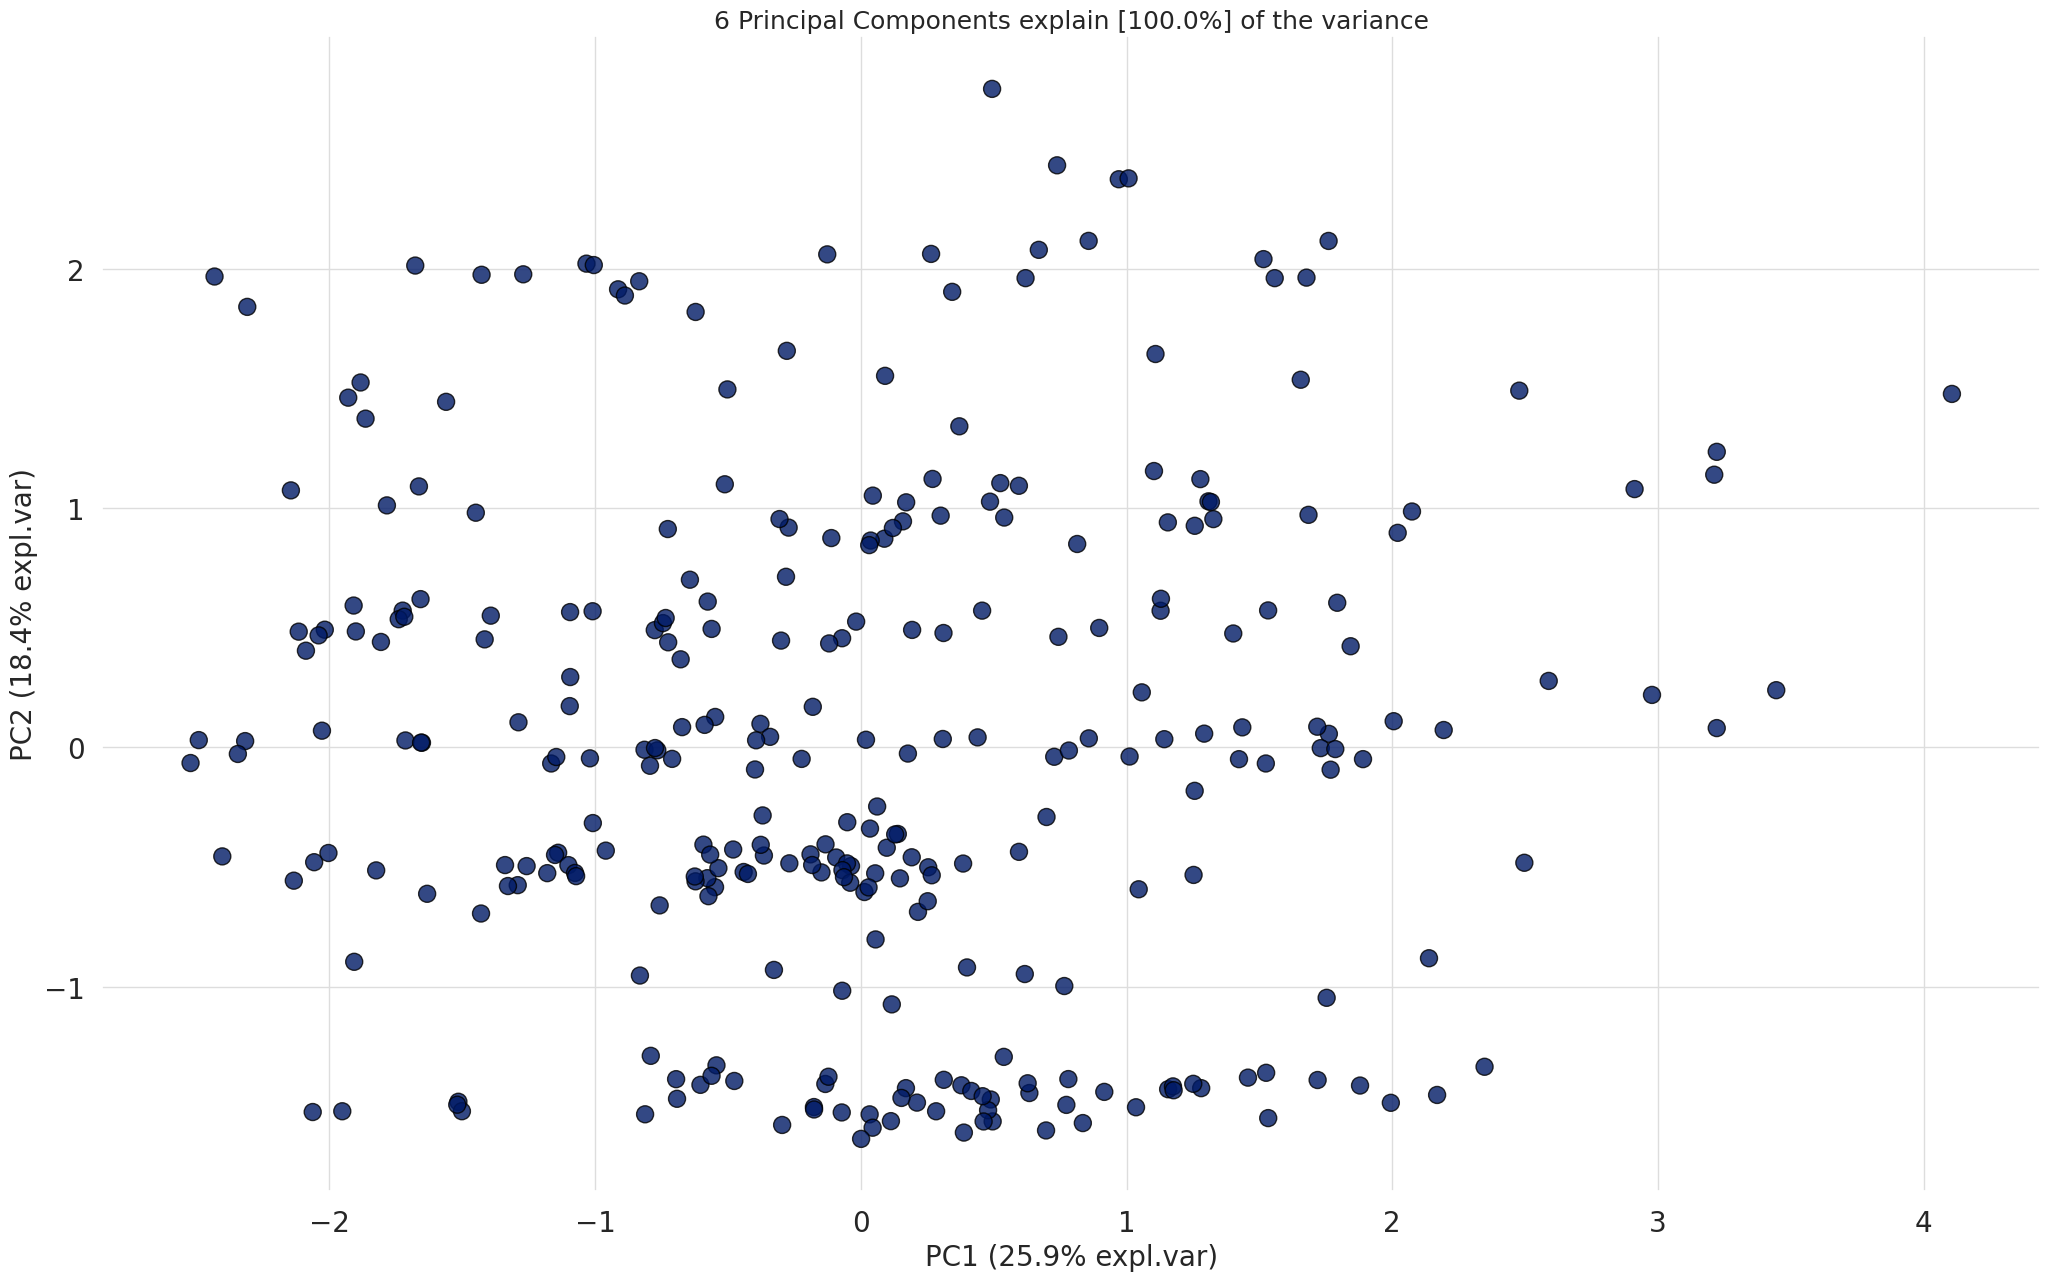

In [26]:
model.scatter(label=True, legend=False)

Eigenvectors

In [27]:
A = out['loadings'].T
A

,PC1,PC2,PC3,PC4,PC5,PC6
age,0.558150,-0.050513,0.102779,-0.403869,0.207612,-0.684938
sex,-0.281048,-0.679100,0.339642,-0.136552,0.557716,0.121591
cp,-0.087131,0.511156,0.687196,0.391733,0.288431,-0.149137
trtbps,0.486020,0.004340,0.486353,-0.337046,-0.257032,0.589543
chol,0.511165,0.091164,-0.373013,0.334106,0.603483,0.339767
restecg,-0.323083,0.516393,-0.161751,-0.662994,0.363867,0.175590


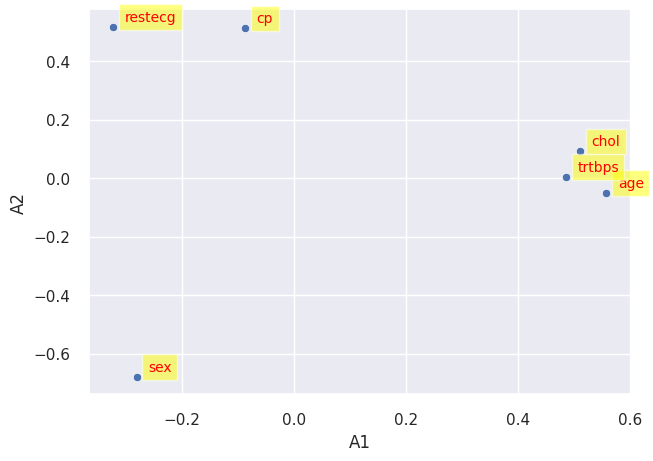

In [28]:
sns.scatterplot(data=A, x="PC1", y="PC2")
plt.xlabel('A1')
plt.ylabel('A2')
for i in range(A.shape[0]):
 plt.text(x=A.PC1[i]+0.02,y=A.PC2[i]+0.02, s=variables[i],
          fontdict=dict(color='red',size=10),
          bbox=dict(facecolor='yellow',alpha=0.5))

Scree Plot

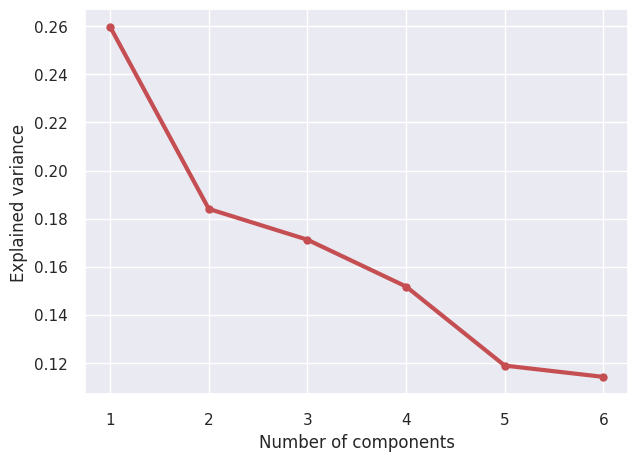

In [29]:
VR = out['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

Explained Variance Plot

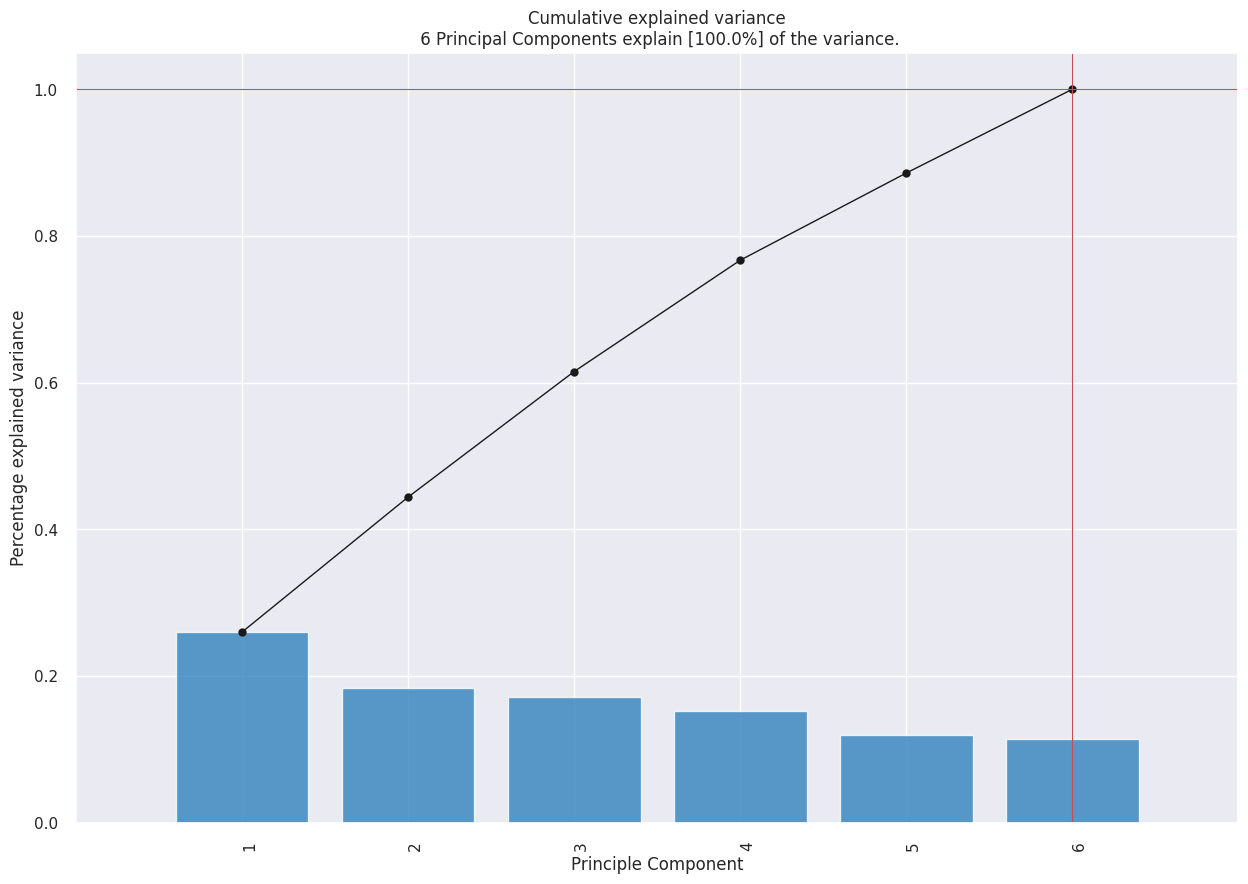

In [30]:
model.plot();

Biplot

[scatterd] >INFO> Create scatterplot


[pca]> [WARNING]: De parameter <label> is deprecated and will not be supported in future version.
[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '6 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.9% expl.var)', ylabel='PC2 (18.4% expl.var)'>)

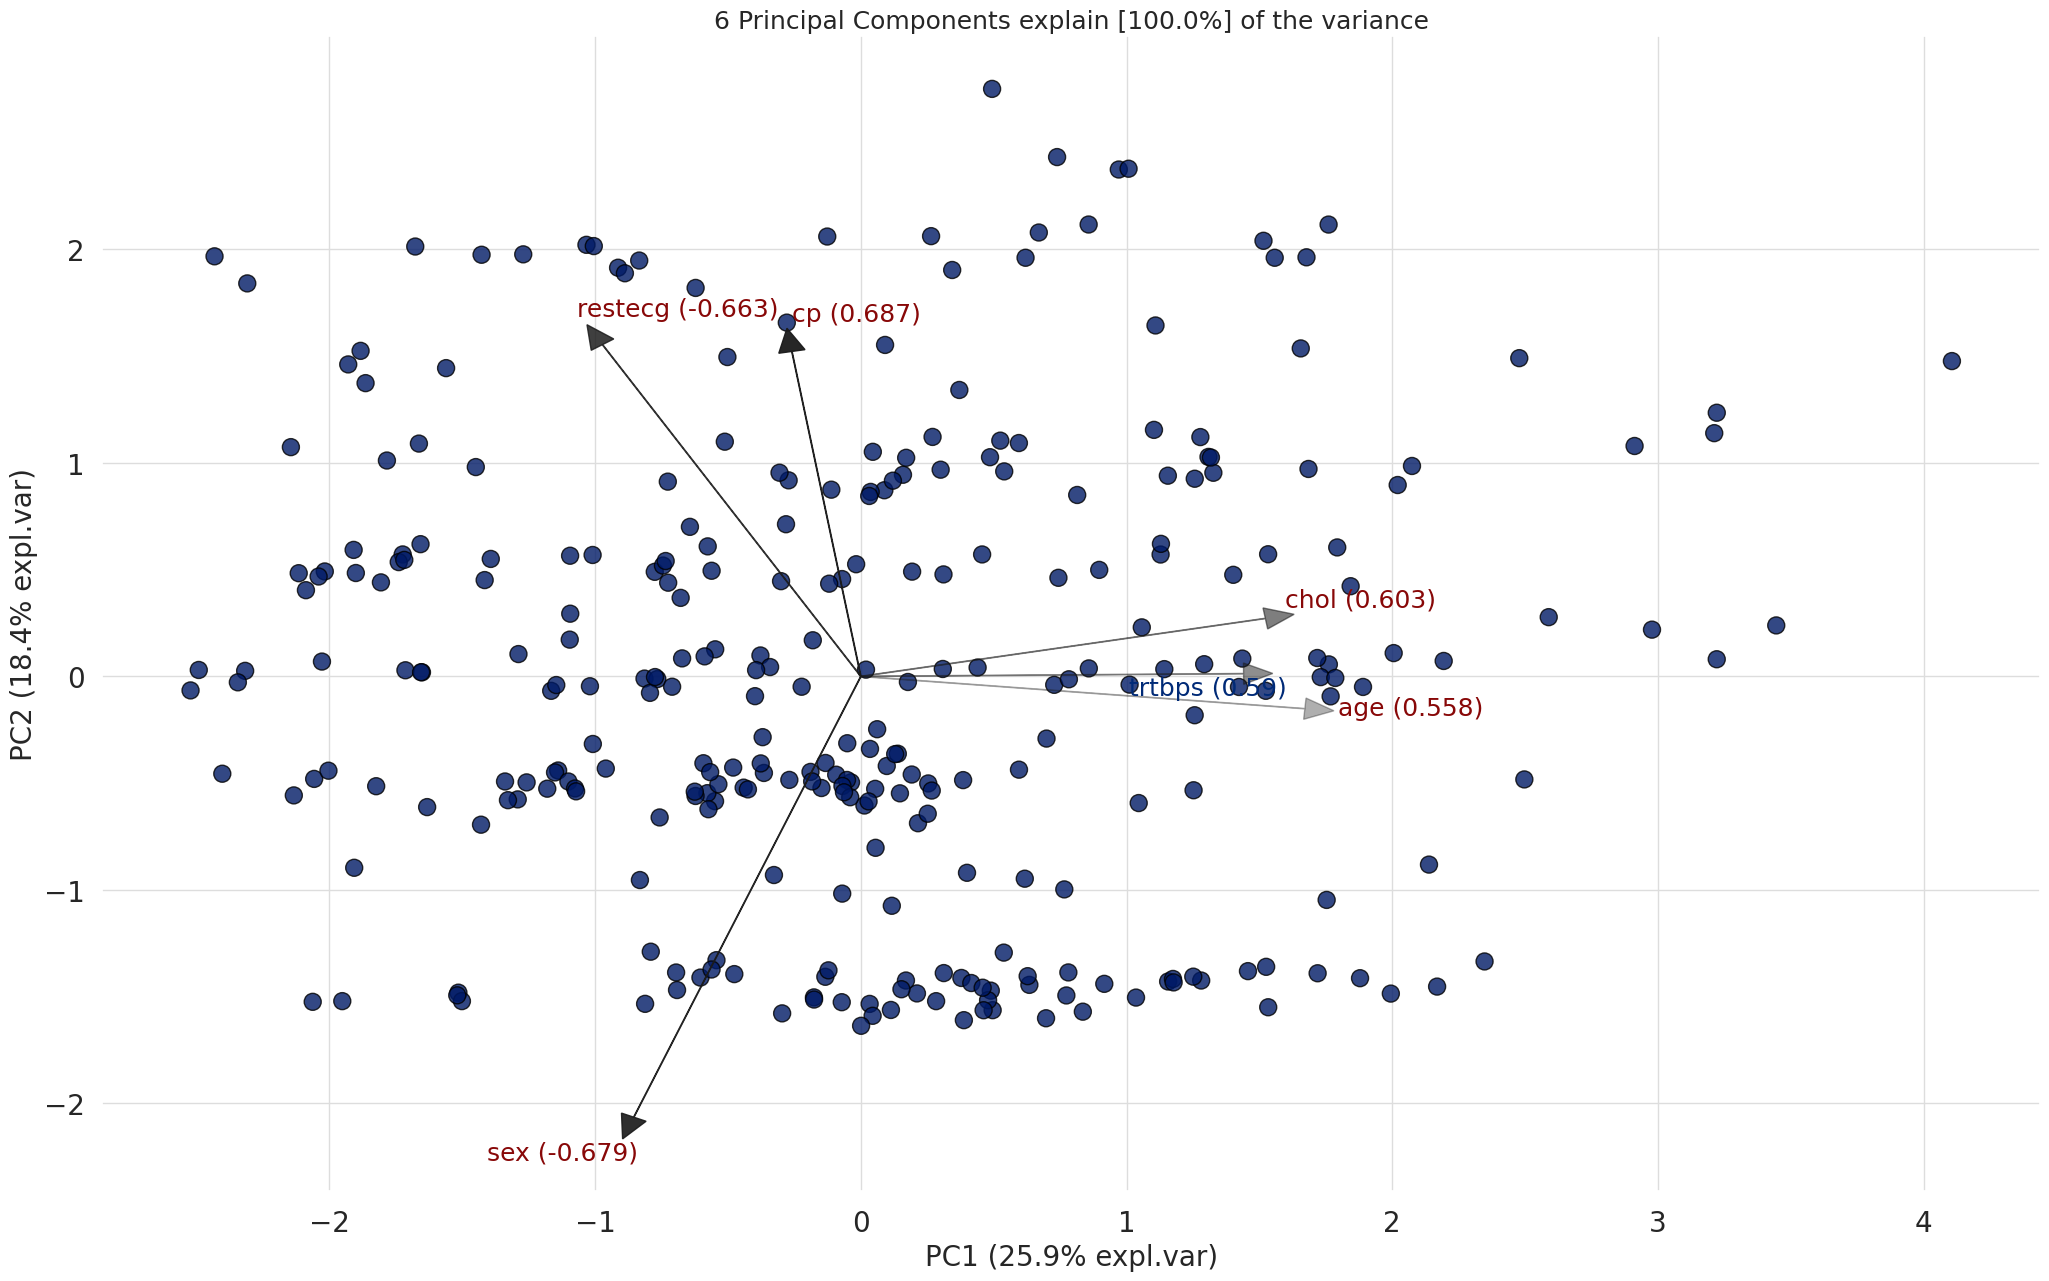

In [31]:
model.biplot(label=False, legend=False, color_arrow='k')

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


(<Figure size 3000x2500 with 1 Axes>,
 <Axes3D: title={'center': '6 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.9% expl.var)', ylabel='PC2 (18.4% expl.var)', zlabel='PC3 (17.1% expl.var)'>)

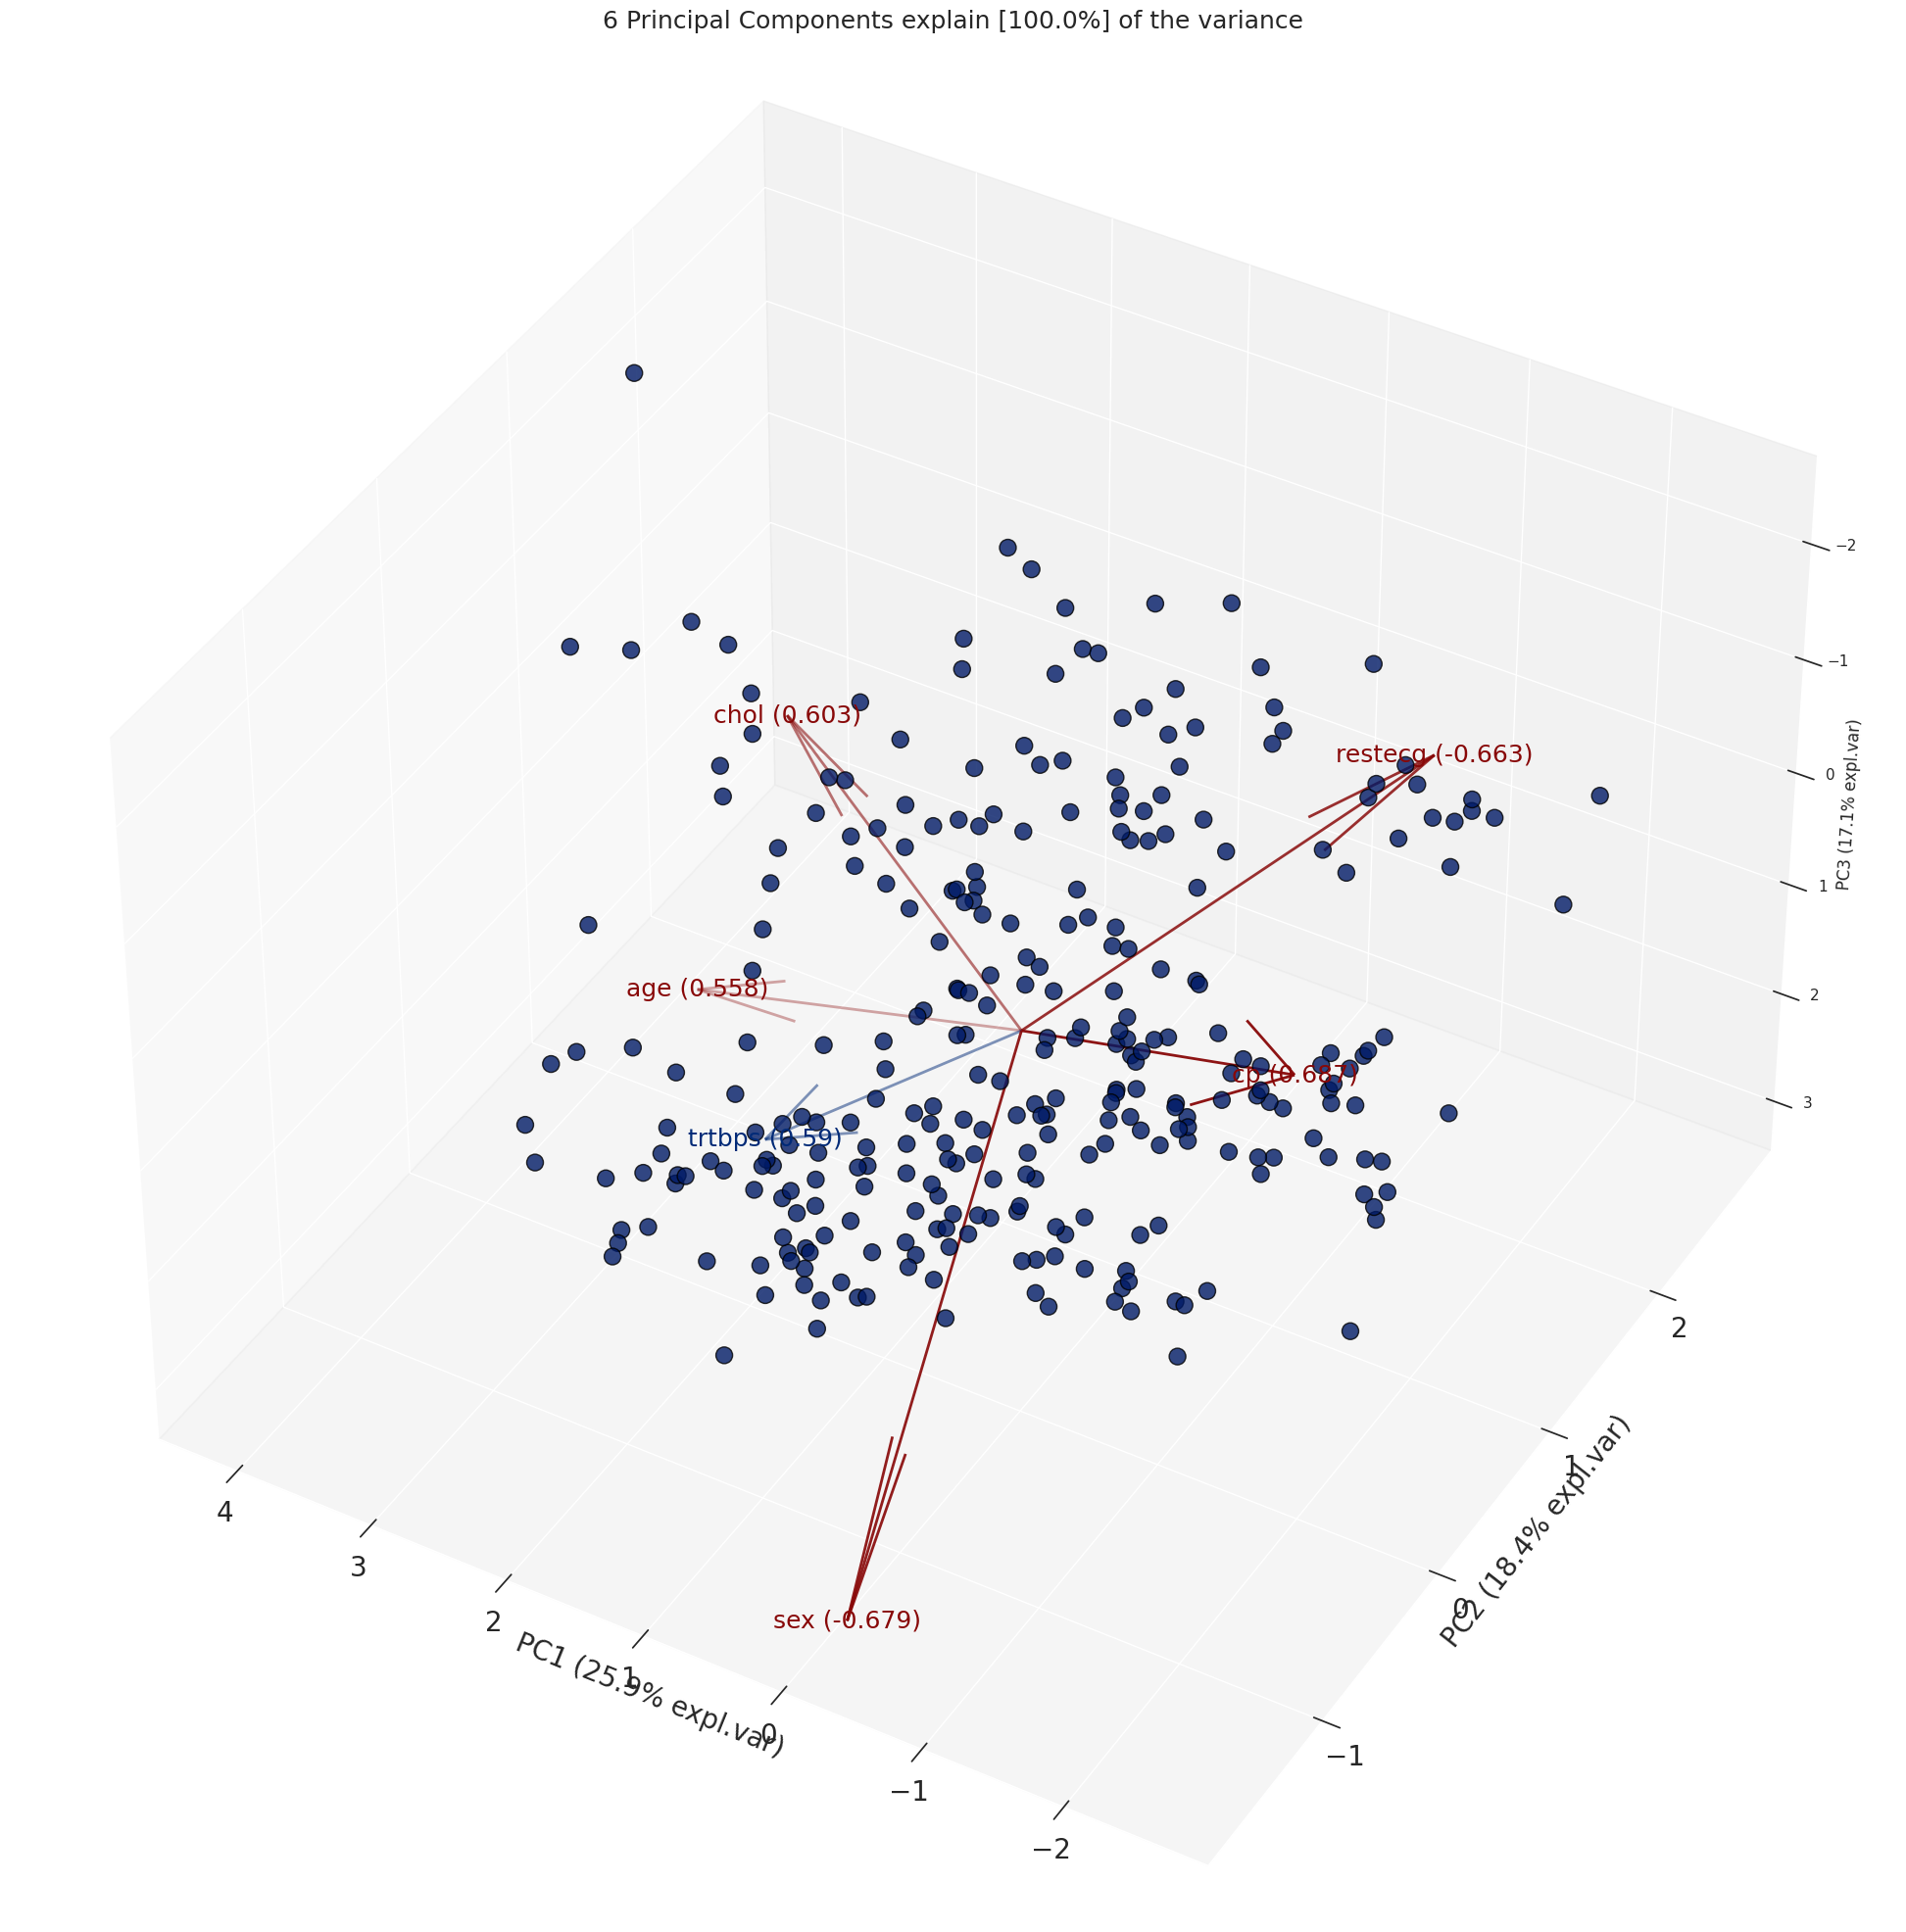

In [32]:
model.biplot3d(legend=False)

## Classification + PCA

In [33]:
clf_pca = setup(data=df, target='output', train_size=0.7, session_id=123, normalize = True, pca = True, pca_components = 3)

results = pull()

print(results)

,Description,Value
0,Session id,123
1,Target,output
2,Target type,Binary
3,Original data shape,"(302, 7)"
4,Transformed data shape,"(302, 4)"
5,Transformed train set shape,"(211, 4)"
6,Transformed test set shape,"(91, 4)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


                    Description             Value
0                    Session id               123
1                        Target            output
2                   Target type            Binary
3           Original data shape          (302, 7)
4        Transformed data shape          (302, 4)
5   Transformed train set shape          (211, 4)
6    Transformed test set shape           (91, 4)
7              Numeric features                 6
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12                    Normalize              True
13             Normalize method            zscore
14                          PCA              True
15                   PCA method            linear
16               PCA components                 3
17               Fold Generator   StratifiedKFold
18                  Fold Number                10


Comparing All Models

In [34]:
best_model_pca = compare_models()

results = pull()

print(results)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7061,0.7731,0.7083,0.7321,0.7163,0.4084,0.4108,0.1070
lda,Linear Discriminant Analysis,0.7061,0.7722,0.7083,0.7321,0.7163,0.4084,0.4108,0.1350
qda,Quadratic Discriminant Analysis,0.7058,0.7531,0.7174,0.7322,0.7219,0.4066,0.4093,0.2440
nb,Naive Bayes,0.7011,0.7633,0.7174,0.7269,0.7194,0.3966,0.3985,0.1550
lr,Logistic Regression,0.6918,0.7713,0.7174,0.7099,0.7099,0.3772,0.3793,1.2300
rf,Random Forest Classifier,0.6913,0.7466,0.8038,0.6847,0.7363,0.3627,0.3803,0.4980
knn,K Neighbors Classifier,0.6870,0.7289,0.7545,0.6989,0.7207,0.3606,0.3702,0.1620
svm,SVM - Linear Kernel,0.6823,0.7328,0.6826,0.7179,0.6898,0.3620,0.3704,0.1100
et,Extra Trees Classifier,0.6818,0.7324,0.7697,0.6892,0.7227,0.3464,0.3590,0.4960
lightgbm,Light Gradient Boosting Machine,0.6773,0.7379,0.7409,0.6774,0.7013,0.3424,0.3548,0.3640


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

                                    Model  Accuracy     AUC  Recall   Prec.  \
ridge                    Ridge Classifier    0.7061  0.7731  0.7083  0.7321   
lda          Linear Discriminant Analysis    0.7061  0.7722  0.7083  0.7321   
qda       Quadratic Discriminant Analysis    0.7058  0.7531  0.7174  0.7322   
nb                            Naive Bayes    0.7011  0.7633  0.7174  0.7269   
lr                    Logistic Regression    0.6918  0.7713  0.7174  0.7099   
rf               Random Forest Classifier    0.6913  0.7466  0.8038  0.6847   
knn                K Neighbors Classifier    0.6870  0.7289  0.7545  0.6989   
svm                   SVM - Linear Kernel    0.6823  0.7328  0.6826  0.7179   
et                 Extra Trees Classifier    0.6818  0.7324  0.7697  0.6892   
lightgbm  Light Gradient Boosting Machine    0.6773  0.7379  0.7409  0.6774   
ada                  Ada Boost Classifier    0.6725  0.7106  0.7258  0.6887   
gbc          Gradient Boosting Classifier    0.6582 

Best model with PCA

In [35]:
best_model_pca

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)

In [36]:
tuned_best_model_pca = tune_model(best_model_pca)

results = pull()

print(results)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8500,0.7500,0.7500,0.7500,0.4500,0.4500
1,0.7619,0.8796,0.7500,0.8182,0.7826,0.5205,0.5230
2,0.9048,0.9630,0.9167,0.9167,0.9167,0.8056,0.8056
3,0.7143,0.7222,0.8333,0.7143,0.7692,0.4000,0.4082
4,0.8095,0.8981,0.8333,0.8333,0.8333,0.6111,0.6111
5,0.5714,0.6000,0.5455,0.6000,0.5714,0.1448,0.1455
6,0.5238,0.6455,0.3636,0.5714,0.4444,0.0625,0.0674
7,0.4762,0.5727,0.5455,0.5000,0.5217,-0.0548,-0.0550
8,0.8095,0.8273,0.8182,0.8182,0.8182,0.6182,0.6182


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7273  0.8500  0.7500  0.7500  0.7500  0.4500  0.4500
1       0.7619  0.8796  0.7500  0.8182  0.7826  0.5205  0.5230
2       0.9048  0.9630  0.9167  0.9167  0.9167  0.8056  0.8056
3       0.7143  0.7222  0.8333  0.7143  0.7692  0.4000  0.4082
4       0.8095  0.8981  0.8333  0.8333  0.8333  0.6111  0.6111
5       0.5714  0.6000  0.5455  0.6000  0.5714  0.1448  0.1455
6       0.5238  0.6455  0.3636  0.5714  0.4444  0.0625  0.0674
7       0.4762  0.5727  0.5455  0.5000  0.5217 -0.0548 -0.0550
8       0.8095  0.8273  0.8182  0.8182  0.8182  0.6182  0.6182
9       0.7619  0.7727  0.8182  0.7500  0.7826  0.5205  0.5230
Mean    0.7061  0.7731  0.7174  0.7272  0.7190  0.4078  0.4097
Std     0.1311  0.1268  0.1653  

Evaluate Best Model

In [37]:
evaluate_model(tuned_best_model_pca)

results = pull()

print(results)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7273  0.8500  0.7500  0.7500  0.7500  0.4500  0.4500
1       0.7619  0.8796  0.7500  0.8182  0.7826  0.5205  0.5230
2       0.9048  0.9630  0.9167  0.9167  0.9167  0.8056  0.8056
3       0.7143  0.7222  0.8333  0.7143  0.7692  0.4000  0.4082
4       0.8095  0.8981  0.8333  0.8333  0.8333  0.6111  0.6111
5       0.5714  0.6000  0.5455  0.6000  0.5714  0.1448  0.1455
6       0.5238  0.6455  0.3636  0.5714  0.4444  0.0625  0.0674
7       0.4762  0.5727  0.5455  0.5000  0.5217 -0.0548 -0.0550
8       0.8095  0.8273  0.8182  0.8182  0.8182  0.6182  0.6182
9       0.7619  0.7727  0.8182  0.7500  0.7826  0.5205  0.5230
Mean    0.7061  0.7731  0.7174  0.7272  0.7190  0.4078  0.4097
Std     0.1311  0.1268  0.1653  0.1253  0.1448  0.2595  0.2590


# Random Forest Classifier Model

In [38]:
rf_pca = create_model('rf')

results = pull()

print(results)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8250,0.9167,0.7857,0.8462,0.6271,0.6383
1,0.8571,0.8426,1.0000,0.8000,0.8889,0.6957,0.7303
2,0.7143,0.8981,1.0000,0.6667,0.8000,0.3636,0.4714
3,0.6190,0.6944,0.8333,0.6250,0.7143,0.1765,0.1936
4,0.7619,0.8102,0.8333,0.7692,0.8000,0.5070,0.5095
5,0.6667,0.6227,0.7273,0.6667,0.6957,0.3288,0.3303
6,0.4762,0.4955,0.6364,0.5000,0.5600,-0.0645,-0.0674
7,0.5714,0.6000,0.6364,0.5833,0.6087,0.1370,0.1376
8,0.6667,0.7727,0.6364,0.7000,0.6667,0.3348,0.3364


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8182  0.8250  0.9167  0.7857  0.8462  0.6271  0.6383
1       0.8571  0.8426  1.0000  0.8000  0.8889  0.6957  0.7303
2       0.7143  0.8981  1.0000  0.6667  0.8000  0.3636  0.4714
3       0.6190  0.6944  0.8333  0.6250  0.7143  0.1765  0.1936
4       0.7619  0.8102  0.8333  0.7692  0.8000  0.5070  0.5095
5       0.6667  0.6227  0.7273  0.6667  0.6957  0.3288  0.3303
6       0.4762  0.4955  0.6364  0.5000  0.5600 -0.0645 -0.0674
7       0.5714  0.6000  0.6364  0.5833  0.6087  0.1370  0.1376
8       0.6667  0.7727  0.6364  0.7000  0.6667  0.3348  0.3364
9       0.7619  0.9045  0.8182  0.7500  0.7826  0.5205  0.5230
Mean    0.6913  0.7466  0.8038  0.6847  0.7363  0.3627  0.3803
Std     0.1101  0.1306  0.1348  0.0915  0.1000  0.2228  0.2309


Tuning Random Forest Classifier Model

In [39]:
tuned_rf_pca = tune_model(rf_pca)

results = pull()

print(results)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7727,0.8250,0.8333,0.7692,0.8000,0.5378,0.5401
1,0.8095,0.8056,0.8333,0.8333,0.8333,0.6111,0.6111
2,0.8095,0.9630,1.0000,0.7500,0.8571,0.5882,0.6455
3,0.7143,0.8056,0.8333,0.7143,0.7692,0.4000,0.4082
4,0.7619,0.8519,0.9167,0.7333,0.8148,0.4928,0.5173
5,0.5714,0.6545,0.6364,0.5833,0.6087,0.1370,0.1376
6,0.5238,0.5636,0.4545,0.5556,0.5000,0.0541,0.0550
7,0.4286,0.5818,0.5455,0.4615,0.5000,-0.1560,-0.1589
8,0.7143,0.7909,0.7273,0.7273,0.7273,0.4273,0.4273


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7727  0.8250  0.8333  0.7692  0.8000  0.5378  0.5401
1       0.8095  0.8056  0.8333  0.8333  0.8333  0.6111  0.6111
2       0.8095  0.9630  1.0000  0.7500  0.8571  0.5882  0.6455
3       0.7143  0.8056  0.8333  0.7143  0.7692  0.4000  0.4082
4       0.7619  0.8519  0.9167  0.7333  0.8148  0.4928  0.5173
5       0.5714  0.6545  0.6364  0.5833  0.6087  0.1370  0.1376
6       0.5238  0.5636  0.4545  0.5556  0.5000  0.0541  0.0550
7       0.4286  0.5818  0.5455  0.4615  0.5000 -0.1560 -0.1589
8       0.7143  0.7909  0.7273  0.7273  0.7273  0.4273  0.4273
9       0.8095  0.8455  0.9091  0.7692  0.8333  0.6147  0.6264
Mean    0.6916  0.7687  0.7689  0.6897  0.7244  0.3707  0.3810
Std     0.1289  0.1212  0.1660  0.1105  0.1309  0.2537  0.2621


Evaluating tuned random forest classifier model

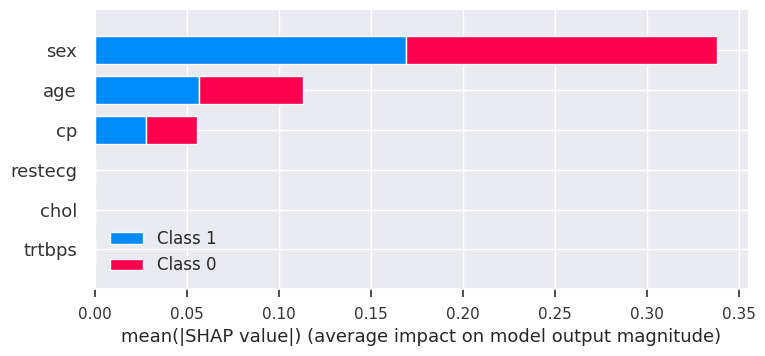

In [40]:
explainer = shap.TreeExplainer(tuned_rf_pca)

shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

# Extra Trees Classifier Model

In [41]:
et_pca = create_model('et')

results = pull()

print(results)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.7583,0.9167,0.7857,0.8462,0.6271,0.6383
1,0.7143,0.8241,0.8333,0.7143,0.7692,0.4000,0.4082
2,0.7619,0.8519,1.0000,0.7059,0.8276,0.4776,0.5601
3,0.6190,0.6111,0.8333,0.6250,0.7143,0.1765,0.1936
4,0.7619,0.8380,0.7500,0.8182,0.7826,0.5205,0.5230
5,0.6667,0.6727,0.6364,0.7000,0.6667,0.3348,0.3364
6,0.4762,0.6136,0.6364,0.5000,0.5600,-0.0645,-0.0674
7,0.6190,0.5409,0.7273,0.6154,0.6667,0.2294,0.2337
8,0.7143,0.7636,0.7273,0.7273,0.7273,0.4273,0.4273


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8182  0.7583  0.9167  0.7857  0.8462  0.6271  0.6383
1       0.7143  0.8241  0.8333  0.7143  0.7692  0.4000  0.4082
2       0.7619  0.8519  1.0000  0.7059  0.8276  0.4776  0.5601
3       0.6190  0.6111  0.8333  0.6250  0.7143  0.1765  0.1936
4       0.7619  0.8380  0.7500  0.8182  0.7826  0.5205  0.5230
5       0.6667  0.6727  0.6364  0.7000  0.6667  0.3348  0.3364
6       0.4762  0.6136  0.6364  0.5000  0.5600 -0.0645 -0.0674
7       0.6190  0.5409  0.7273  0.6154  0.6667  0.2294  0.2337
8       0.7143  0.7636  0.7273  0.7273  0.7273  0.4273  0.4273
9       0.6667  0.8500  0.6364  0.7000  0.6667  0.3348  0.3364
Mean    0.6818  0.7324  0.7697  0.6892  0.7227  0.3464  0.3590
Std     0.0917  0.1088  0.1183  0.0860  0.0824  0.1864  0.1945


Tuning Extra Trees Classifier Model

In [42]:
tuned_et_pca = tune_model(et_pca)

results = pull()

print(results)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7727,0.8417,0.8333,0.7692,0.8000,0.5378,0.5401
1,0.8095,0.8519,1.0000,0.7500,0.8571,0.5882,0.6455
2,0.7619,0.9259,1.0000,0.7059,0.8276,0.4776,0.5601
3,0.7619,0.7037,0.9167,0.7333,0.8148,0.4928,0.5173
4,0.7143,0.9074,1.0000,0.6667,0.8000,0.3636,0.4714
5,0.6667,0.6545,0.7273,0.6667,0.6957,0.3288,0.3303
6,0.6667,0.6545,0.7273,0.6667,0.6957,0.3288,0.3303
7,0.3810,0.6182,0.6364,0.4375,0.5185,-0.2698,-0.3091
8,0.7143,0.8000,0.8182,0.6923,0.7500,0.4220,0.4301


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7727  0.8417  0.8333  0.7692  0.8000  0.5378  0.5401
1       0.8095  0.8519  1.0000  0.7500  0.8571  0.5882  0.6455
2       0.7619  0.9259  1.0000  0.7059  0.8276  0.4776  0.5601
3       0.7619  0.7037  0.9167  0.7333  0.8148  0.4928  0.5173
4       0.7143  0.9074  1.0000  0.6667  0.8000  0.3636  0.4714
5       0.6667  0.6545  0.7273  0.6667  0.6957  0.3288  0.3303
6       0.6667  0.6545  0.7273  0.6667  0.6957  0.3288  0.3303
7       0.3810  0.6182  0.6364  0.4375  0.5185 -0.2698 -0.3091
8       0.7143  0.8000  0.8182  0.6923  0.7500  0.4220  0.4301
9       0.8095  0.8273  0.9091  0.7692  0.8333  0.6147  0.6264
Mean    0.7058  0.7785  0.8568  0.6857  0.7593  0.3885  0.4142
Std     0.1188  0.1061  0.1233  0.0914  0.0961  0.2397  0.2621


Evaluating tuned extra trees classifier model

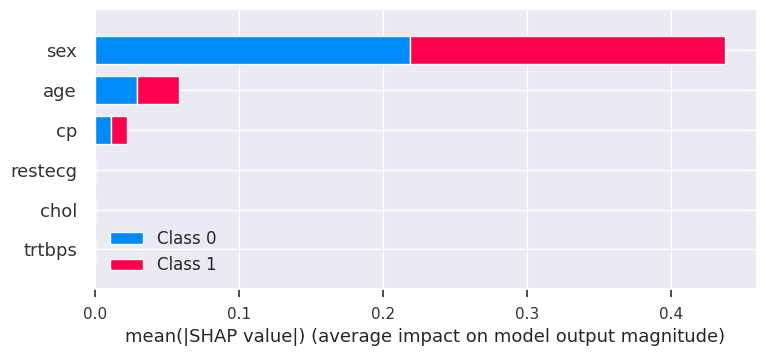

In [43]:
explainer = shap.TreeExplainer(tuned_et_pca)

shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

# Logistic Regression Model

In [44]:
lr_pca = create_model('lr')

results = pull()

print(results)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7273,0.8500,0.7500,0.7500,0.7500,0.4500,0.4500
1,0.7619,0.8704,0.7500,0.8182,0.7826,0.5205,0.5230
2,0.8571,0.9630,0.9167,0.8462,0.8800,0.7042,0.7077
3,0.7143,0.7222,0.8333,0.7143,0.7692,0.4000,0.4082
4,0.7619,0.8981,0.8333,0.7692,0.8000,0.5070,0.5095
5,0.5714,0.6000,0.5455,0.6000,0.5714,0.1448,0.1455
6,0.5238,0.6455,0.3636,0.5714,0.4444,0.0625,0.0674
7,0.4286,0.5727,0.5455,0.4615,0.5000,-0.1560,-0.1589
8,0.8095,0.8182,0.8182,0.8182,0.8182,0.6182,0.6182


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.7273  0.8500  0.7500  0.7500  0.7500  0.4500  0.4500
1       0.7619  0.8704  0.7500  0.8182  0.7826  0.5205  0.5230
2       0.8571  0.9630  0.9167  0.8462  0.8800  0.7042  0.7077
3       0.7143  0.7222  0.8333  0.7143  0.7692  0.4000  0.4082
4       0.7619  0.8981  0.8333  0.7692  0.8000  0.5070  0.5095
5       0.5714  0.6000  0.5455  0.6000  0.5714  0.1448  0.1455
6       0.5238  0.6455  0.3636  0.5714  0.4444  0.0625  0.0674
7       0.4286  0.5727  0.5455  0.4615  0.5000 -0.1560 -0.1589
8       0.8095  0.8182  0.8182  0.8182  0.8182  0.6182  0.6182
9       0.7619  0.7727  0.8182  0.7500  0.7826  0.5205  0.5230
Mean    0.6918  0.7713  0.7174  0.7099  0.7099  0.3772  0.3793
Std     0.1303  0.1257  0.1653  0.1190  0.1408  0.2581  0.2590


Tuning Logistic Regression Model

In [45]:
tuned_lr_pca = tune_model(lr_pca)

results = pull()

print(results)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8182,0.8500,0.7500,0.9000,0.8182,0.6393,0.6500
1,0.7619,0.8704,0.7500,0.8182,0.7826,0.5205,0.5230
2,0.9524,0.9630,0.9167,1.0000,0.9565,0.9041,0.9083
3,0.7143,0.7222,0.8333,0.7143,0.7692,0.4000,0.4082
4,0.8571,0.8981,0.8333,0.9091,0.8696,0.7123,0.7156
5,0.6190,0.6000,0.5455,0.6667,0.6000,0.2432,0.2477
6,0.4762,0.6364,0.2727,0.5000,0.3529,-0.0267,-0.0302
7,0.4762,0.5727,0.5455,0.5000,0.5217,-0.0548,-0.0550
8,0.6667,0.8182,0.5455,0.7500,0.6316,0.3408,0.3553


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8182  0.8500  0.7500  0.9000  0.8182  0.6393  0.6500
1       0.7619  0.8704  0.7500  0.8182  0.7826  0.5205  0.5230
2       0.9524  0.9630  0.9167  1.0000  0.9565  0.9041  0.9083
3       0.7143  0.7222  0.8333  0.7143  0.7692  0.4000  0.4082
4       0.8571  0.8981  0.8333  0.9091  0.8696  0.7123  0.7156
5       0.6190  0.6000  0.5455  0.6667  0.6000  0.2432  0.2477
6       0.4762  0.6364  0.2727  0.5000  0.3529 -0.0267 -0.0302
7       0.4762  0.5727  0.5455  0.5000  0.5217 -0.0548 -0.0550
8       0.6667  0.8182  0.5455  0.7500  0.6316  0.3408  0.3553
9       0.6667  0.7727  0.6364  0.7000  0.6667  0.3348  0.3364
Mean    0.7009  0.7704  0.6629  0.7458  0.6969  0.4014  0.4059
Std     0.1467  0.1267  0.1822  0.1583  0.1697  0.2906  0.2927


Evaluating tuned logistic regression model

In [47]:
import shap

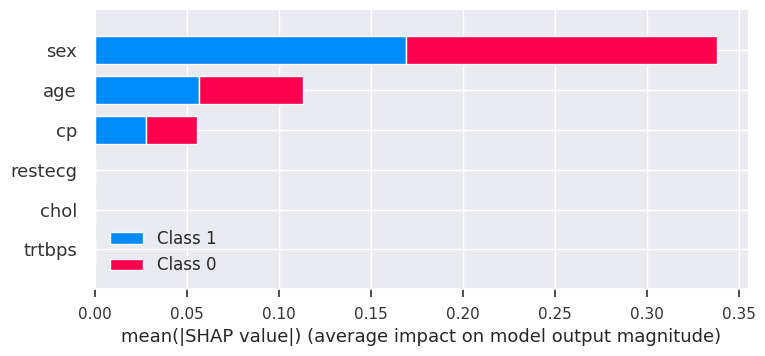

In [49]:
explainer = shap.TreeExplainer(tuned_rf_pca)

shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

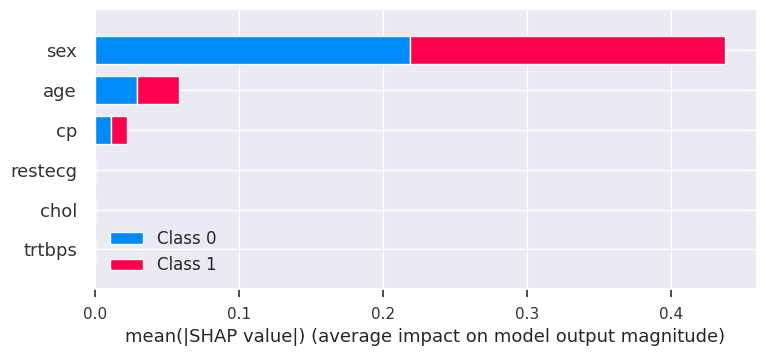

In [51]:

explainer = shap.TreeExplainer(tuned_et_pca)

shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [53]:
selected_data = X.iloc[:, :3]
background_data = selected_data.sample(100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

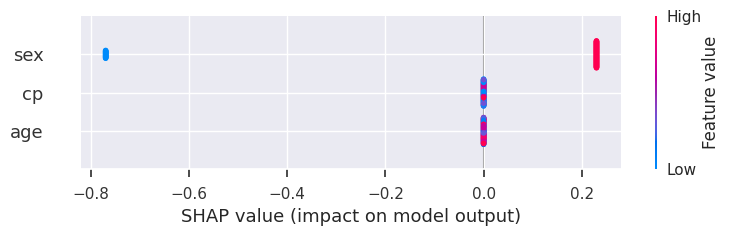

In [54]:
# Create the KernelExplainer using the preprocessed background data
explainer = shap.KernelExplainer(tuned_lr_pca.predict, background_data)

shap_values = explainer.shap_values(background_data)

shap.summary_plot(shap_values, background_data)